## Part 3 - Words that characterize Computational Social Science communities

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ast
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.util import bigrams
import re
from collections import Counter
from scipy.stats import chi2
from nltk.tokenize import MWETokenizer
import json
from networkx.readwrite import json_graph
import community.community_louvain as community
import networkx as nx
from wordcloud import WordCloud
import textwrap


nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /Users/sadsa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/sadsa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Getting requirements needed for the exercises

#### Assignment of each author to their network community, and the degree of each author (relevent parts of week 6, ex 4)

In [130]:
# Compute the best partition (community assignment) using the louvain mathod 
partition = community.best_partition(Graph)

# get the degree of each author
degrees = dict(Graph.degree())

# number of communities
num_communities = len(set(partition.values()))
print(f"Number of communities found: {num_communities}")

# community sizes
community_sizes = Counter(partition.values())
print("Community sizes:", community_sizes)

# compute modularity
modularity = community.modularity(partition, Graph)
print(f"Modularity: {modularity:.4f}")

Number of communities found: 514
Community sizes: Counter({10: 1328, 8: 919, 15: 630, 13: 577, 4: 572, 11: 559, 3: 551, 34: 525, 28: 463, 17: 461, 31: 399, 9: 393, 40: 360, 0: 358, 30: 327, 26: 303, 24: 287, 32: 268, 60: 261, 6: 248, 12: 245, 47: 222, 87: 221, 55: 204, 42: 194, 29: 190, 35: 188, 44: 175, 45: 165, 52: 163, 78: 146, 63: 137, 37: 135, 81: 135, 23: 124, 27: 116, 20: 109, 16: 95, 104: 91, 49: 86, 122: 85, 53: 72, 7: 69, 18: 64, 59: 59, 74: 57, 124: 52, 93: 50, 77: 45, 159: 45, 98: 44, 167: 40, 89: 39, 22: 34, 88: 34, 70: 31, 85: 27, 117: 27, 118: 26, 147: 25, 80: 24, 126: 24, 69: 23, 58: 22, 160: 21, 73: 20, 75: 18, 156: 18, 171: 18, 46: 17, 84: 17, 99: 17, 72: 15, 144: 15, 153: 15, 125: 14, 57: 13, 79: 13, 92: 13, 111: 13, 112: 13, 135: 13, 158: 13, 33: 12, 95: 12, 143: 12, 149: 12, 155: 12, 51: 11, 108: 11, 177: 11, 66: 10, 133: 10, 54: 9, 76: 9, 90: 9, 97: 9, 136: 9, 145: 9, 151: 9, 161: 9, 162: 9, 170: 9, 103: 8, 107: 8, 138: 8, 140: 8, 173: 8, 176: 8, 64: 7, 116: 7, 14

In [131]:
# save author-community-degree (acd) data to a dataframe
df_acd = pd.DataFrame(list(partition.items()), columns=["author_id", "community"]) 
df_acd["degree"] = df_acd["author_id"].map(degrees)

In [132]:
df_acd

,author_id,community,degree
0,https://openalex.org/A5067008528,0,6
1,https://openalex.org/A5022754313,0,25
2,https://openalex.org/A5044056170,0,4
3,https://openalex.org/A5012701585,0,17
4,https://openalex.org/A5071496598,0,15
...,...,...,...
15096,https://openalex.org/A5007313170,1,0
15097,https://openalex.org/A5070124321,2,0
15098,https://openalex.org/A5025112887,5,0
15099,https://openalex.org/A5007178020,19,0


#### Get the tokenized abstracts dataframe (relevent parts of week 7, ex 2)

In [102]:
df_abstracts = pd.read_csv('final_abstracts.csv')

In [103]:
df_abstracts.head()

,id,title,abstract_inverted_index
0,https://openalex.org/W3129422154,Expectations of reward and efficacy guide cogn...,"{'The': [0], 'amount': [1], 'of': [2, 26, 62, ..."
1,https://openalex.org/W4392375089,An experimental manipulation of the value of e...,NaN
2,https://openalex.org/W3087570498,The impact of COVID-19 on the gender division ...,"{'As': [0], 'most': [1, 161], 'other': [2], 'E..."
3,https://openalex.org/W2905008240,The strength of long-range ties in population-...,"{'The': [0], 'strength': [1], 'of': [2, 80], '..."
4,https://openalex.org/W3129992849,Promises and Perils of Experimentation: The Mu...,"{'Researchers': [0], 'run': [1], 'experiments'..."


Convert inverted index to text

In [104]:
# convert 'abstract_inverted_index' column from string to dictionary
df_abstracts['abstract_inverted_index'] = df_abstracts['abstract_inverted_index'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# remove rows where 'abstract_inverted_index' is nan or empty dictionary
df_abstracts = df_abstracts[df_abstracts['abstract_inverted_index'].apply(lambda x: isinstance(x, dict) and bool(x))]


In [105]:
# Define the function to convert the inverted index to plain text
def convert_inverted_to_text(inverted_index_str):
    
    # create list to hold the words in the correct order based on indices
    reconstructed_abstract = [''] * (max(max(indexes) for indexes in inverted_index_str.values()) + 1)
    
    # place each word at the corresponding index
    for word, indexes in inverted_index_str.items():
        for index in indexes:
            reconstructed_abstract[index] = word
            
    return ' '.join(reconstructed_abstract)

In [106]:
# Create new column 'text' in df_abstracts 
df_abstracts['text'] = df_abstracts['abstract_inverted_index'].apply(convert_inverted_to_text)

In [107]:
df_abstracts.head()

,id,title,abstract_inverted_index,text
0,https://openalex.org/W3129422154,Expectations of reward and efficacy guide cogn...,"{'The': [0], 'amount': [1], 'of': [2, 26, 62, ...",The amount of mental effort we invest in a tas...
2,https://openalex.org/W3087570498,The impact of COVID-19 on the gender division ...,"{'As': [0], 'most': [1, 161], 'other': [2], 'E...","As most other EU countries, Hungary implemente..."
3,https://openalex.org/W2905008240,The strength of long-range ties in population-...,"{'The': [0], 'strength': [1], 'of': [2, 80], '...",The strength of long-range ties It seems reaso...
4,https://openalex.org/W3129992849,Promises and Perils of Experimentation: The Mu...,"{'Researchers': [0], 'run': [1], 'experiments'...","Researchers run experiments to test theories, ..."
5,https://openalex.org/W4386387636,High level of correspondence across different ...,"{'Abstract': [0], 'One': [1], 'widely': [2], '...",Abstract One widely used approach for quantify...


Tokenization

In [108]:
# initialize the stemmer
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))  # load stopwords (to remove common words later)

In [110]:
# Define a function for tokenization, removal of stopwords (e.g., in, an, on, the, etc.), stemming (e.g., running -> run)

def tokenize_text(given_text):

    # convert to lowercase
    given_text = given_text.lower()
    
    # remove URLs, punctuation, numbers, and mathematical symbols
    given_text = re.sub(r"http\S+|www\S+", "", given_text)  # remove URLs
    given_text = re.sub(r"[^a-zA-Z\s]", "", given_text)  # keep only letters and spaces
    
    # tokenize
    tokens = word_tokenize(given_text)
    
    # remove stopwords and apply stemming
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    
    return tokens

In [111]:
# create new column 'tokens' in df_abstracts
df_abstracts['tokens'] = df_abstracts['text'].apply(tokenize_text)

In [112]:
df_abstracts.head()

,id,title,abstract_inverted_index,text,tokens
0,https://openalex.org/W3129422154,Expectations of reward and efficacy guide cogn...,"{'The': [0], 'amount': [1], 'of': [2, 26, 62, ...",The amount of mental effort we invest in a tas...,"[amount, mental, effort, invest, task, influen..."
2,https://openalex.org/W3087570498,The impact of COVID-19 on the gender division ...,"{'As': [0], 'most': [1, 161], 'other': [2], 'E...","As most other EU countries, Hungary implemente...","[eu, countri, hungari, implement, sever, lockd..."
3,https://openalex.org/W2905008240,The strength of long-range ties in population-...,"{'The': [0], 'strength': [1], 'of': [2, 80], '...",The strength of long-range ties It seems reaso...,"[strength, longrang, tie, seem, reason, would,..."
4,https://openalex.org/W3129992849,Promises and Perils of Experimentation: The Mu...,"{'Researchers': [0], 'run': [1], 'experiments'...","Researchers run experiments to test theories, ...","[research, run, experi, test, theori, search, ..."
5,https://openalex.org/W4386387636,High level of correspondence across different ...,"{'Abstract': [0], 'One': [1], 'widely': [2], '...",Abstract One widely used approach for quantify...,"[abstract, one, wide, use, approach, quantifi,..."


In [113]:
# Add column of bigrams for each abstract 
df_abstracts['bigrams'] = df_abstracts['tokens'].apply(lambda tokens: list(bigrams(tokens)))

In [119]:
df_abstracts.head()

,id,title,abstract_inverted_index,text,tokens,bigrams
0,https://openalex.org/W3129422154,Expectations of reward and efficacy guide cogn...,"{'The': [0], 'amount': [1], 'of': [2, 26, 62, ...",The amount of mental effort we invest in a tas...,"[amount, mental, effort, invest, task, influen...","[(amount, mental), (mental, effort), (effort, ..."
2,https://openalex.org/W3087570498,The impact of COVID-19 on the gender division ...,"{'As': [0], 'most': [1, 161], 'other': [2], 'E...","As most other EU countries, Hungary implemente...","[eu, countri, hungari, implement, sever, lockd...","[(eu, countri), (countri, hungari), (hungari, ..."
3,https://openalex.org/W2905008240,The strength of long-range ties in population-...,"{'The': [0], 'strength': [1], 'of': [2, 80], '...",The strength of long-range ties It seems reaso...,"[strength, longrang, tie, seem, reason, would,...","[(strength, longrang), (longrang, tie), (tie, ..."
4,https://openalex.org/W3129992849,Promises and Perils of Experimentation: The Mu...,"{'Researchers': [0], 'run': [1], 'experiments'...","Researchers run experiments to test theories, ...","[research, run, experi, test, theori, search, ...","[(research, run), (run, experi), (experi, test..."
5,https://openalex.org/W4386387636,High level of correspondence across different ...,"{'Abstract': [0], 'One': [1], 'widely': [2], '...",Abstract One widely used approach for quantify...,"[abstract, one, wide, use, approach, quantifi,...","[(abstract, one), (one, wide), (wide, use), (u..."


In [115]:
# Combine bigrams into a single string for each abstract (note about 2-4 minutes to run)
all_bigrams = sum(df_abstracts["bigrams"].tolist(), [])

Compute contingency tables

In [120]:
# count occurences of all bigrams 
bigram_counts = Counter(all_bigrams)

In [121]:
# get unique words 
all_words = sum(df_abstracts["tokens"].tolist(), [])  # flatten token list
word_counts = Counter(all_words)
total_words = len(all_words)

In [122]:
all_words[:10], all_bigrams[:10]

(['amount',
  'mental',
  'effort',
  'invest',
  'task',
  'influenc',
  'reward',
  'expect',
  'perform',
  'task'],
 [('amount', 'mental'),
  ('mental', 'effort'),
  ('effort', 'invest'),
  ('invest', 'task'),
  ('task', 'influenc'),
  ('influenc', 'reward'),
  ('reward', 'expect'),
  ('expect', 'perform'),
  ('perform', 'task'),
  ('task', 'well')])

In [123]:
bigram_stats = []
for (word1, word2), bigram_count in bigram_counts.items():
    
    # get observed counts (variable names are from theory in lecture notes)
    nii = bigram_count 
    nio = word_counts[word1] - bigram_count # bigrams where first word is word1 and second word is not word2
    noi = word_counts[word2] - bigram_count # bigrams where first word is not word1 and second word is word2
    noo = total_words - (nii + nio + noi) # bigrams where first word is not word1 and second word is not word2

    # get expected counts
    R1 = nii + nio # the bigrams containing word1 (sum of first row)
    C1 = nii + noi # the bigrams containing word2 (sum of first column)
    R2 = noi + noo # the bigrams not containing word1 (sum of second row)
    C2 = nio + noo # the bigrams not containing word2 (sum of second column)

    N = nii + nio + noi + noo # total number of bigrams

    E11 = (R1 * C1) / N
    E12 = (R1 * C2) / N
    E13 = (R2 * C1) / N
    E14 = (R2 * C2) / N

    # compute chi-squared statistic
    chi_square = sum(
        (O - E) ** 2 / E
        for O, E in zip([nii, nio, noi, noo], [E11, E12, E13, E14])
        if E > 0
    )

    # compute p-value
    p_value = chi2.sf(chi_square, df=1)

    bigram_stats.append((word1, word2, nii, chi_square, p_value))


In [124]:
# convert to dataframe
bigram_df = pd.DataFrame(bigram_stats, columns=["word1", "word2", "count", "chi2", "p_value"])

In [125]:
bigram_df.head()

,word1,word2,count,chi2,p_value
0,amount,mental,2,3.159056,7.550685e-02
1,mental,effort,21,519.078782,6.713755e-115
2,effort,invest,11,315.358333,1.485865e-70
3,invest,task,6,6.391010,1.146997e-02
4,task,influenc,5,5.888028,1.524416e-02


In [126]:
# Identify collocations i.e., find bigrams that appear more than 50 times and have p-value < 0.001
collocations = bigram_df[(bigram_df["count"] > 50) & (bigram_df["p_value"] < 0.001)]
collocations_sorted = collocations.sort_values(by="count", ascending=False)

print(collocations_sorted.head(20))

            word1    word2  count          chi2  p_value
877        social    media   3570  3.676996e+05      0.0
183        social  network   2802  8.516929e+04      0.0
2659       result     show   1558  4.007759e+04      0.0
4012       machin    learn   1355  1.943633e+05      0.0
1376       neural  network   1094  9.936744e+04      0.0
2577        paper  present    986  4.083884e+04      0.0
382        result  suggest    949  2.981371e+04      0.0
191            et       al    907  2.144077e+06      0.0
977          data  collect    885  2.855053e+04      0.0
2972         data      set    857  1.612777e+04      0.0
13674       paper   propos    821  2.451014e+04      0.0
1063        decis     make    793  8.279499e+04      0.0
1378        natur  languag    774  1.024890e+05      0.0
2817        googl  scholar    767  1.179650e+06      0.0
22356  experiment   result    743  4.626869e+04      0.0
32389    reinforc    learn    724  1.055572e+05      0.0
2785         unit    state    6

In [127]:
# Recompute tokens using MWETokenizer

# create list of collocations as tuples
collocation_tuples = [tuple(x) for x in collocations_sorted[["word1", "word2"]].values]

# initialize MWETokenizer
tokenizer = MWETokenizer(collocation_tuples)

# apply tokenizer to the 'tokens' column
df_abstracts['tokens'] = df_abstracts['tokens'].apply(lambda x: tokenizer.tokenize(x))

In [128]:
df_abstracts.head()

,id,title,abstract_inverted_index,text,tokens,bigrams
0,https://openalex.org/W3129422154,Expectations of reward and efficacy guide cogn...,"{'The': [0], 'amount': [1], 'of': [2, 26, 62, ...",The amount of mental effort we invest in a tas...,"[amount, mental, effort, invest, task, influen...","[(amount, mental), (mental, effort), (effort, ..."
2,https://openalex.org/W3087570498,The impact of COVID-19 on the gender division ...,"{'As': [0], 'most': [1, 161], 'other': [2], 'E...","As most other EU countries, Hungary implemente...","[eu, countri, hungari, implement, sever, lockd...","[(eu, countri), (countri, hungari), (hungari, ..."
3,https://openalex.org/W2905008240,The strength of long-range ties in population-...,"{'The': [0], 'strength': [1], 'of': [2, 80], '...",The strength of long-range ties It seems reaso...,"[strength, longrang, tie, seem, reason, would,...","[(strength, longrang), (longrang, tie), (tie, ..."
4,https://openalex.org/W3129992849,Promises and Perils of Experimentation: The Mu...,"{'Researchers': [0], 'run': [1], 'experiments'...","Researchers run experiments to test theories, ...","[research, run, experi_test, theori, search, d...","[(research, run), (run, experi), (experi, test..."
5,https://openalex.org/W4386387636,High level of correspondence across different ...,"{'Abstract': [0], 'One': [1], 'widely': [2], '...",Abstract One widely used approach for quantify...,"[abstract, one, wide_use, approach, quantifi, ...","[(abstract, one), (one, wide), (wide, use), (u..."


We now have the final tokenized abstracts data set called `df_abstracts`

### Exercise 1: TF-IDF and the Computational Social Science communities

Explain in your own words the point of TF-IDF. What does TF stand for? What does IDF stand for?

TF-IDF stands for Term Frequency-Inverse Document Frequency and it measures how important a particular word, is relative to a collection of documents, referred to as the corpus. We use TF-IDF in NLP and text analysis because it identifies important words by downweighting frequent words (such as "the", "is", and "and") and highlights rare but important words in a specific document. This can improve search and information retrieval when search engines use TF-IDF to rank documents by relevance, for example, if a query word has high TF-IDF in a document, then that document would be considered more relevant. TF-IDF can also help with spam detection, sentiment analysis, and keyword extraction. Instead of just counting words like the bag-of-words model which treats all words as equally important, TF-IDF gives weight to words that are important or informative relative to the rest of the documents.

In [208]:
# read in the original dataframes
df_papers_orig = pd.read_csv('final_papers.csv')
df_authors_orig = pd.read_csv('final_authors.csv')

Find out which words are important for each community

In [209]:
# merge df_abstracts with df_papers_orig on 'id' which is the paper id
df_merged1 = df_abstracts.merge(df_papers_orig, on="id", how="left")

In [210]:
df_merged1.head()

,id,title,abstract_inverted_index,text,tokens,bigrams,publication_year,cited_by_count,author_ids
0,https://openalex.org/W3129422154,Expectations of reward and efficacy guide cogn...,"{'The': [0], 'amount': [1], 'of': [2, 26, 62, ...",The amount of mental effort we invest in a tas...,"[amount, mental, effort, invest, task, influen...","[(amount, mental), (mental, effort), (effort, ...",2021,189,"['https://openalex.org/A5067008528', 'https://..."
1,https://openalex.org/W3087570498,The impact of COVID-19 on the gender division ...,"{'As': [0], 'most': [1, 161], 'other': [2], 'E...","As most other EU countries, Hungary implemente...","[eu, countri, hungari, implement, sever, lockd...","[(eu, countri), (countri, hungari), (hungari, ...",2020,124,"['https://openalex.org/A5069473136', 'https://..."
2,https://openalex.org/W2905008240,The strength of long-range ties in population-...,"{'The': [0], 'strength': [1], 'of': [2, 80], '...",The strength of long-range ties It seems reaso...,"[strength, longrang, tie, seem, reason, would,...","[(strength, longrang), (longrang, tie), (tie, ...",2018,90,"['https://openalex.org/A5034327826', 'https://..."
3,https://openalex.org/W3129992849,Promises and Perils of Experimentation: The Mu...,"{'Researchers': [0], 'run': [1], 'experiments'...","Researchers run experiments to test theories, ...","[research, run, experi_test, theori, search, d...","[(research, run), (run, experi), (experi, test...",2021,56,"['https://openalex.org/A5022754313', 'https://..."
4,https://openalex.org/W4386387636,High level of correspondence across different ...,"{'Abstract': [0], 'One': [1], 'widely': [2], '...",Abstract One widely used approach for quantify...,"[abstract, one, wide_use, approach, quantifi, ...","[(abstract, one), (one, wide), (wide, use), (u...",2023,26,"['https://openalex.org/A5022754313', 'https://..."


We now need to separate out each author on its own row in the df_merged1 dataframe. Then we will merge the resulting dataframe with df_acd and then with df_authors_orig on author_id.

In [211]:
df_merged1['author_ids'] = df_merged1['author_ids'].apply(ast.literal_eval) # convert each string to a list

In [212]:
df_merged1_exploded = df_merged1.explode('author_ids') # get each author on a separate row

In [213]:
df_merged1_exploded.head()

,id,title,abstract_inverted_index,text,tokens,bigrams,publication_year,cited_by_count,author_ids
0,https://openalex.org/W3129422154,Expectations of reward and efficacy guide cogn...,"{'The': [0], 'amount': [1], 'of': [2, 26, 62, ...",The amount of mental effort we invest in a tas...,"[amount, mental, effort, invest, task, influen...","[(amount, mental), (mental, effort), (effort, ...",2021,189,https://openalex.org/A5067008528
0,https://openalex.org/W3129422154,Expectations of reward and efficacy guide cogn...,"{'The': [0], 'amount': [1], 'of': [2, 26, 62, ...",The amount of mental effort we invest in a tas...,"[amount, mental, effort, invest, task, influen...","[(amount, mental), (mental, effort), (effort, ...",2021,189,https://openalex.org/A5022754313
0,https://openalex.org/W3129422154,Expectations of reward and efficacy guide cogn...,"{'The': [0], 'amount': [1], 'of': [2, 26, 62, ...",The amount of mental effort we invest in a tas...,"[amount, mental, effort, invest, task, influen...","[(amount, mental), (mental, effort), (effort, ...",2021,189,https://openalex.org/A5044056170
0,https://openalex.org/W3129422154,Expectations of reward and efficacy guide cogn...,"{'The': [0], 'amount': [1], 'of': [2, 26, 62, ...",The amount of mental effort we invest in a tas...,"[amount, mental, effort, invest, task, influen...","[(amount, mental), (mental, effort), (effort, ...",2021,189,https://openalex.org/A5012701585
0,https://openalex.org/W3129422154,Expectations of reward and efficacy guide cogn...,"{'The': [0], 'amount': [1], 'of': [2, 26, 62, ...",The amount of mental effort we invest in a tas...,"[amount, mental, effort, invest, task, influen...","[(amount, mental), (mental, effort), (effort, ...",2021,189,https://openalex.org/A5071496598


In [214]:
# merge df_merged1_exploded with df_acd on 'author_ids' and 'author_id'
df_merged2 = df_merged1_exploded.merge(df_acd, left_on="author_ids", right_on="author_id", how="left")
df_merged2 = df_merged2.drop(columns=["author_ids"]) # remove the author_ids column as we already have author_id

In [215]:
df_merged2.head(20)

,id,title,abstract_inverted_index,text,tokens,bigrams,publication_year,cited_by_count,author_id,community,degree
0,https://openalex.org/W3129422154,Expectations of reward and efficacy guide cogn...,"{'The': [0], 'amount': [1], 'of': [2, 26, 62, ...",The amount of mental effort we invest in a tas...,"[amount, mental, effort, invest, task, influen...","[(amount, mental), (mental, effort), (effort, ...",2021,189,https://openalex.org/A5067008528,0,6
1,https://openalex.org/W3129422154,Expectations of reward and efficacy guide cogn...,"{'The': [0], 'amount': [1], 'of': [2, 26, 62, ...",The amount of mental effort we invest in a tas...,"[amount, mental, effort, invest, task, influen...","[(amount, mental), (mental, effort), (effort, ...",2021,189,https://openalex.org/A5022754313,0,25
2,https://openalex.org/W3129422154,Expectations of reward and efficacy guide cogn...,"{'The': [0], 'amount': [1], 'of': [2, 26, 62, ...",The amount of mental effort we invest in a tas...,"[amount, mental, effort, invest, task, influen...","[(amount, mental), (mental, effort), (effort, ...",2021,189,https://openalex.org/A5044056170,0,4
3,https://openalex.org/W3129422154,Expectations of reward and efficacy guide cogn...,"{'The': [0], 'amount': [1], 'of': [2, 26, 62, ...",The amount of mental effort we invest in a tas...,"[amount, mental, effort, invest, task, influen...","[(amount, mental), (mental, effort), (effort, ...",2021,189,https://openalex.org/A5012701585,0,17
4,https://openalex.org/W3129422154,Expectations of reward and efficacy guide cogn...,"{'The': [0], 'amount': [1], 'of': [2, 26, 62, ...",The amount of mental effort we invest in a tas...,"[amount, mental, effort, invest, task, influen...","[(amount, mental), (mental, effort), (effort, ...",2021,189,https://openalex.org/A5071496598,0,15
5,https://openalex.org/W3087570498,The impact of COVID-19 on the gender division ...,"{'As': [0], 'most': [1, 161], 'other': [2], 'E...","As most other EU countries, Hungary implemente...","[eu, countri, hungari, implement, sever, lockd...","[(eu, countri), (countri, hungari), (hungari, ...",2020,124,https://openalex.org/A5069473136,42,3
6,https://openalex.org/W3087570498,The impact of COVID-19 on the gender division ...,"{'As': [0], 'most': [1, 161], 'other': [2], 'E...","As most other EU countries, Hungary implemente...","[eu, countri, hungari, implement, sever, lockd...","[(eu, countri), (countri, hungari), (hungari, ...",2020,124,https://openalex.org/A5045510685,42,3
7,https://openalex.org/W3087570498,The impact of COVID-19 on the gender division ...,"{'As': [0], 'most': [1, 161], 'other': [2], 'E...","As most other EU countries, Hungary implemente...","[eu, countri, hungari, implement, sever, lockd...","[(eu, countri), (countri, hungari), (hungari, ...",2020,124,https://openalex.org/A5084303908,42,15
8,https://openalex.org/W3087570498,The impact of COVID-19 on the gender division ...,"{'As': [0], 'most': [1, 161], 'other': [2], 'E...","As most other EU countries, Hungary implemente...","[eu, countri, hungari, implement, sever, lockd...","[(eu, countri), (countri, hungari), (hungari, ...",2020,124,https://openalex.org/A5051996438,42,3
9,https://openalex.org/W2905008240,The strength of long-range ties in population-...,"{'The': [0], 'strength': [1], 'of': [2, 80], '...",The strength of long-range ties It seems reaso...,"[strength, longrang, tie, seem, reason, would,...","[(strength, longrang), (longrang, tie), (tie, ...",2018,90,https://openalex.org/A5034327826,9,7


In [216]:
# merge df_merged2 with df_authors_orig
df_final = pd.merge(df_merged2, df_authors_orig, left_on="author_id", right_on="id", how="left")
df_final = df_final.drop(columns=["id_y"]) # remove id_y as we already have author_id column. note that id_x is the paper id now

In [217]:
df_final.head(20)

,id_x,title,abstract_inverted_index,text,tokens,bigrams,publication_year,cited_by_count_x,author_id,community,degree,display_name,cited_by_count_y,h_index,works_count,country_code,works_api_url
0,https://openalex.org/W3129422154,Expectations of reward and efficacy guide cogn...,"{'The': [0], 'amount': [1], 'of': [2, 26, 62, ...",The amount of mental effort we invest in a tas...,"[amount, mental, effort, invest, task, influen...","[(amount, mental), (mental, effort), (effort, ...",2021,189,https://openalex.org/A5067008528,0,6,Romy Frömer,744.0,12.0,44.0,US,https://api.openalex.org/works?filter=author.i...
1,https://openalex.org/W3129422154,Expectations of reward and efficacy guide cogn...,"{'The': [0], 'amount': [1], 'of': [2, 26, 62, ...",The amount of mental effort we invest in a tas...,"[amount, mental, effort, invest, task, influen...","[(amount, mental), (mental, effort), (effort, ...",2021,189,https://openalex.org/A5022754313,0,25,Hause Lin,1480.0,16.0,74.0,CA,https://api.openalex.org/works?filter=author.i...
2,https://openalex.org/W3129422154,Expectations of reward and efficacy guide cogn...,"{'The': [0], 'amount': [1], 'of': [2, 26, 62, ...",The amount of mental effort we invest in a tas...,"[amount, mental, effort, invest, task, influen...","[(amount, mental), (mental, effort), (effort, ...",2021,189,https://openalex.org/A5044056170,0,4,Carolyn K. Dean Wolf,298.0,4.0,7.0,US,https://api.openalex.org/works?filter=author.i...
3,https://openalex.org/W3129422154,Expectations of reward and efficacy guide cogn...,"{'The': [0], 'amount': [1], 'of': [2, 26, 62, ...",The amount of mental effort we invest in a tas...,"[amount, mental, effort, invest, task, influen...","[(amount, mental), (mental, effort), (effort, ...",2021,189,https://openalex.org/A5012701585,0,17,Michael Inzlicht,21310.0,70.0,341.0,CA,https://api.openalex.org/works?filter=author.i...
4,https://openalex.org/W3129422154,Expectations of reward and efficacy guide cogn...,"{'The': [0], 'amount': [1], 'of': [2, 26, 62, ...",The amount of mental effort we invest in a tas...,"[amount, mental, effort, invest, task, influen...","[(amount, mental), (mental, effort), (effort, ...",2021,189,https://openalex.org/A5071496598,0,15,Amitai Shenhav,8486.0,36.0,141.0,US,https://api.openalex.org/works?filter=author.i...
5,https://openalex.org/W3087570498,The impact of COVID-19 on the gender division ...,"{'As': [0], 'most': [1, 161], 'other': [2], 'E...","As most other EU countries, Hungary implemente...","[eu, countri, hungari, implement, sever, lockd...","[(eu, countri), (countri, hungari), (hungari, ...",2020,124,https://openalex.org/A5069473136,42,3,Éva Fodor,1358.0,21.0,70.0,AT,https://api.openalex.org/works?filter=author.i...
6,https://openalex.org/W3087570498,The impact of COVID-19 on the gender division ...,"{'As': [0], 'most': [1, 161], 'other': [2], 'E...","As most other EU countries, Hungary implemente...","[eu, countri, hungari, implement, sever, lockd...","[(eu, countri), (countri, hungari), (hungari, ...",2020,124,https://openalex.org/A5045510685,42,3,Anikó Gregor,263.0,6.0,26.0,HU,https://api.openalex.org/works?filter=author.i...
7,https://openalex.org/W3087570498,The impact of COVID-19 on the gender division ...,"{'As': [0], 'most': [1, 161], 'other': [2], 'E...","As most other EU countries, Hungary implemente...","[eu, countri, hungari, implement, sever, lockd...","[(eu, countri), (countri, hungari), (hungari, ...",2020,124,https://openalex.org/A5084303908,42,15,Júlia Koltai,432.0,11.0,60.0,HU,https://api.openalex.org/works?filter=author.i...
8,https://openalex.org/W3087570498,The impact of COVID-19 on the gender division ...,"{'As': [0], 'most': [1, 161], 'other': [2], 'E...","As most other EU countries, Hungary implemente...","[eu, countri, hungari, implement, sever, lockd...","[(eu, countri), (countri, hungari), (hungari, ...",2020,124,https://openalex.org/A5051996438,42,3,Eszter Kováts,140.0,2.0,3.0,HU,https://api.openalex.org/works?filter=author.i...
9,https:/

We now have the final dataframe called `df_final` with all the information we need to proceed with exercise 1.

Now, we want to find out which words are important for each community, so we're going to create several *large documents, one for each community*

In [218]:
# make a dictionary where each key is the community and value is the list of all the tokens in that community
comm_docs = df_final.groupby("community")["tokens"].apply(lambda x: sum(x, [])).to_dict() 

# store back into a dataframe
df_comm_docs = pd.DataFrame(comm_docs.items(), columns=["community", "tokens"])

In [219]:
# just checking
df_comm_docs.isna().sum()

community    0
tokens       0
dtype: int64

In [220]:
df_comm_docs.head()

,community,tokens
0,0,"[amount, mental, effort, invest, task, influen..."
1,3,"[strength, longrang, tie, seem, reason, would,..."
2,4,"[abstract, one, wide_use, approach, quantifi, ..."
3,6,"[abstract, gener, artifici_intellig, ai, model..."
4,7,"[book, consist, chapter, divid, seven, part, s..."


Use the method of your choice to find the top 5 terms within the top 5 communities (by number of authors).

The weight scheme used will be raw count.

In [221]:
# count number of authors per community 
author_counts = df_final.groupby('community')['author_id'].nunique().sort_values(ascending=False)

# get top 5 communities by author_counts
top_5_communities = author_counts.head(5).index.tolist()
top_5_communities

[10, 8, 15, 13, 4]

In [222]:
# filter df_comm_docs to get the tokens for the top 5 communities
top_5_community_tokens = df_comm_docs[df_comm_docs['community'].isin(top_5_communities)]
top_5_community_tokens.head()

,community,tokens
2,4,"[abstract, one, wide_use, approach, quantifi, ..."
5,8,"[text_gener, larg_languag, model, prolifer, be..."
7,10,"[conflict, fuel, popular, religi, mobil, rekin..."
10,13,"[world, digit, inform, ecosystem, continu, str..."
12,15,"[abstract, one, wide_use, approach, quantifi, ..."


In [ ]:
# find the top 5 terms in each of the top 5 communities

top_5_exploded = top_5_community_tokens.explode('tokens') # get each token on a separate row

# count occurences of each token in each community
term_counts = top_5_exploded.groupby(["community"])["tokens"].value_counts()

# get top 5 terms for each community
top_5_terms_per_community = (
    term_counts.groupby(level=0)  # group by community (note that term_counts is a pandas Series)
    .nlargest(5)  # get 5 most frequent terms 
    .reset_index(level=0, drop=True)  # reset index for cleaner output
)

# convert to dictionary-like format for easy access while printing
top_5_terms_dict = (
    top_5_terms_per_community.groupby(level=0)
    .apply(lambda x: list(x.index.get_level_values(1)))  # extract just the tokens (words) from the index
    .to_dict()
)

# print results
for community, terms in top_5_terms_dict.items():
    print(f"Community {community}: {terms}")

Community 4: ['use', 'peopl', 'effect', 'inform', 'model']
Community 8: ['model', 'use', 'task', 'gener', 'system']
Community 10: ['use', 'user', 'design', 'commun', 'particip']
Community 13: ['user', 'network', 'use', 'model', 'studi']
Community 15: ['polit', 'effect', 'use', 'find', 'studi']


Describe similarities and differences between the communities.

[Note that the similarities and differences discussed below will be based on the 5 top frequent token list for the top 5 communities.]

Similarities: The word "use" appears in all five communities, indicating a broad interest in practical applications or methodologies. The word "model" appears in Communities 4, 8, and 13, suggesting that these communities could have a strong focus on modeling approaches. The presence of words like "polit" (politics) in Community 15, "commun" (communication) in Community 10, and "network" in Community 13 suggests that some communities have a social science or interdisciplinary focus, integrating computational methods with societal studies.

Differences: Community 8 contains "model", "task", "system", which aligns more with AI, machine learning, or computational task-solving while community 10 includes "design" "commun" (communication) and "particip" (participation), indicating a focus on user-centered research, participatory design, or communication systems.

Why aren't the TFs not necessarily a good description of the communities?

TFs alone may not be the best descriptrs because high-frequency words like "use" and "model" appear in multiple communities, making them less effective at differentiating between different research focuses. These frequent words may be general terms used across various fields rather than terms specific to a particular community. TF counts also do not capture the meaning or context of words. For example, "model" could refer to statistical models, AI models, or conceptual models, depending on the research area. Hence, communities with different focuses may share common words but discuss entirely different topics.

Next, we calculate IDF for every token in each of the top 5 communities. We will do this by implementing the following formula on the words (adapted from: https://en.wikipedia.org/wiki/Tf%E2%80%93idf):

$$
\text{IDF}(w) = \log \frac{N}{1 + df(w)}
$$

where:  
   - $N$ = total number of communities  
   - $df(w)$ = number of communities in which the word appears  
   - Adding 1 in the denominator prevents division by zero.

In [ ]:
# get unique words in each of the top 5 communities
word_in_communities = top_5_exploded.groupby("tokens")["community"].nunique()

# total number of communities 
tot_num = df_comm_docs["community"].nunique()

# compute idf
idf_scores = np.log(tot_num / (1 + word_in_communities))

# convert to a DataFrame for readability
idf_df = idf_scores.reset_index()
idf_df.columns = ["word", "IDF"]

In [226]:
idf_df

,word,IDF
0,aa,3.676301
1,aaa,4.369448
2,aaai,3.676301
3,aab,4.369448
4,aac,4.369448
...,...,...
34720,zuco,3.963983
34721,zuom,4.369448
34722,zurich,3.676301
34723,zuylen,3.963983


What base logarithm did you use? Is that important?

By default, base e was used. While the choice of base affects the actual numerical values of IDF scores, it doesn't affect the ranking of words (since logarithms of different bases are proportional to each other). Hence, it effectively does not make a difference. 

We're ready to calculate TF-IDF. Do that for the top 9 communities (by number of authors).

In [227]:
# get top 9 communities by author_counts
top_9_communities = author_counts.head(9).index.tolist()
top_9_communities

[10, 8, 15, 13, 4, 11, 3, 34, 28]

In [229]:
# filter df_comm_docs to get the tokens for the top 9 communities
top_9_community_tokens = df_comm_docs[df_comm_docs['community'].isin(top_9_communities)]
top_9_community_tokens.head(9)

,community,tokens
1,3,"[strength, longrang, tie, seem, reason, would,..."
2,4,"[abstract, one, wide_use, approach, quantifi, ..."
5,8,"[text_gener, larg_languag, model, prolifer, be..."
7,10,"[conflict, fuel, popular, religi, mobil, rekin..."
8,11,"[abstract, unpreced, behaviour, respons, socie..."
10,13,"[world, digit, inform, ecosystem, continu, str..."
12,15,"[abstract, one, wide_use, approach, quantifi, ..."
24,28,"[complex, mani, biolog, social, technolog, sys..."
30,34,"[applaud, matz, et_al, use, field_studi, faceb..."


In [ ]:
# compute tf (weighting is based on raw count)
top_9_exploded = top_9_community_tokens.explode('tokens') # get each token on a separate row
tf = top_9_exploded.groupby(["community"])["tokens"].value_counts()

In [279]:
# compute document frequency for each word (i.e., number of communities in which the word appears)
df = df_final.explode('tokens').groupby("tokens")["community"].nunique()

# compute df using log base e
N = df_comm_docs["community"].nunique()
idf = np.log(N / (1 + df))

IDF can be calculated by multiplying tf and df.

In [280]:
tf_idf = tf * idf

# convert to DataFrame for readability
tf_idf_dataframe = tf_idf.reset_index()
tf_idf_dataframe.columns = ["community", "tokens", "tf-idf"]

In [281]:
tf_idf_dataframe

,community,tokens,tf-idf
0,3,model,700.814330
1,3,individu,830.481412
2,3,popul,976.240623
3,3,cooper,1520.218772
4,3,use,315.016632
...,...,...,...
116437,34,zhu,2.760010
116438,34,zhuo,3.963983
116439,34,zinkevich,3.453157
116440,34,zone,1.596859


For each community in the top 9, list the top 10 TF words

In [282]:
# get top 10 tf words for each community
top_10_tf_words = (
    tf.groupby(level=0)  # group by community 
    .nlargest(10)  # get 10 most frequent terms 
    .reset_index(level=0, drop=True)  # reset index for cleaner output
)

# convert to dictionary-like format for easy access while printing
top_10_tf_words_dict = (
    top_10_tf_words.groupby(level=0)
    .apply(lambda x: list(x.index.get_level_values(1)))  # extract just the tokens (words) from the index
    .to_dict()
)

# print top 10 words for each community
for community, words in top_10_tf_words_dict.items():
    print(f"Community {community} - Top 10 TF words: {words}")

Community 3 - Top 10 TF words: ['model', 'individu', 'popul', 'cooper', 'use', 'system', 'dynam', 'result', 'time', 'gener']
Community 4 - Top 10 TF words: ['use', 'peopl', 'effect', 'inform', 'model', 'differ', 'particip', 'decis', 'individu', 'research']
Community 8 - Top 10 TF words: ['model', 'use', 'task', 'gener', 'system', 'data', 'learn', 'dataset', 'method', 'perform']
Community 10 - Top 10 TF words: ['use', 'user', 'design', 'commun', 'particip', 'system', 'data', 'task', 'peopl', 'research']
Community 11 - Top 10 TF words: ['network', 'model', 'find', 'use', 'dynam', 'system', 'studi', 'individu', 'differ', 'distribut']
Community 13 - Top 10 TF words: ['user', 'network', 'use', 'model', 'studi', 'data', 'inform', 'differ', 'commun', 'system']
Community 15 - Top 10 TF words: ['polit', 'effect', 'use', 'find', 'studi', 'inform', 'data', 'research', 'measur', 'polici']
Community 28 - Top 10 TF words: ['model', 'agent', 'use', 'individu', 'cultur', 'gener', 'show', 'human', 'alg

For each community in the top 9, list the top 10 TF-IDF words

In [283]:
# get top 10 tf-idf words for each community
top_10_tfidf_words = (
    tf_idf.groupby(level=0)  # group by community 
    .nlargest(10)   
    .reset_index(level=0, drop=True)  # reset index for cleaner output
)

# convert to dictionary-like format for easy access while printing
top_10_tfidf_words_dict = (
    top_10_tfidf_words.groupby(level=0)
    .apply(lambda x: list(x.index.get_level_values(1)))  # extract just the tokens (words) from the index
    .to_dict()
)

# print
for community, words in top_10_tfidf_words_dict.items():
    print(f"Community {community} - Top 10 TF-IDF words: {words}")

Community 3 - Top 10 TF-IDF words: ['cooper', 'popul', 'influenza', 'individu', 'dynam', 'transmiss', 'speci', 'epidem', 'model', 'leprosi']
Community 4 - Top 10 TF-IDF words: ['peopl', 'misinform', 'judgment', 'decis', 'heurist', 'particip', 'survey', 'respond', 'cognit', 'choic']
Community 8 - Top 10 TF-IDF words: ['task', 'model', 'dataset', 'text', 'word', 'languag', 'natur_languag', 'annot', 'learn', 'user']
Community 10 - Top 10 TF-IDF words: ['user', 'commun', 'design', 'peopl', 'particip', 'task', 'social_media', 'onlin', 'interact', 'visual']
Community 11 - Top 10 TF-IDF words: ['network', 'dynam', 'find', 'node', 'expon', 'distribut', 'individu', 'citi', 'model', 'scale']
Community 13 - Top 10 TF-IDF words: ['user', 'network', 'twitter', 'social_media', 'epidem', 'bot', 'spread', 'social', 'commun', 'popular']
Community 15 - Top 10 TF-IDF words: ['polit', 'elect', 'belief', 'voter', 'vote', 'partisan', 'social_media', 'parti', 'polici', 'news']
Community 28 - Top 10 TF-IDF wo

Are these 10 words more descriptive of the community? If yes, what is it about IDF that makes the words more informative?



Yes, the 10 words in the TF-IDF list are more descriptive of the community compared to just the term frequency (TF) words. 

For example, we can see for Community 3 TF words like "cooper" (coorperation), "population", "system," and "model" tell us the community might be interested in fields such as sociology, behavioral economics, epidemiology, or complex systems, especially as they relate to modelling population behaviors, cooperation, or the evolution of systems over time. However, with TF-IDF words, the inclusion of words like "influenza," "transmiss," "epidem," and "leprosi" points to a strong public health or epidemiological focus within the community. The community may be concerned with modeling the transmission of diseases and understanding how diseases spread within populations.

The key reason lies in how the inverse document frequency (IDF) works to highlight the most informative terms. Term Frequency (TF) measures how often a word appears in a specific community or document. While this is helpful to identify common terms, it doesn't account for the uniqueness or distinctiveness of those words across different communities. Inverse Document Frequency (IDF), on the other hand, helps highlight words that are not only frequent within a given community but also less frequent across all communities. The higher the IDF of a word, the more unique it is to the community, as it appears in fewer other communities.

For each community in the top 9, the top 3 authors.

In [266]:
# get all the info on the authors for the top 9 communities by filtering df_final
df_top_9_comms = df_final[df_final["community"].isin(top_9_communities)]

# get top 3 authors by degree in each community
top_3_authors = (
    df_top_9_comms.drop_duplicates(subset=["community", "display_name"]) # remove the duplicate author names (these duplicates exist because each author can have multiple papers)
    .groupby("community")
    .apply(lambda x: x.nlargest(3, "degree"))  # select top 3 authors by degree
    .reset_index(drop=True)
)

# print
for community, group in top_3_authors.groupby("community"):
    print(f"Community {community} - Top 3 authors by degree:")
    print(group[["display_name", "degree"]])  

Community 3 - Top 3 authors by degree:
          display_name  degree
0       Simon A. Levin     277
1  Mauricio Santillana      70
2   Taylor H. Ricketts      58
Community 4 - Top 3 authors by degree:
          display_name  degree
3  Stephan Lewandowsky     189
4        Ralph Hertwig     144
5       Susan T. Fiske      93
Community 8 - Top 3 authors by degree:
           display_name  degree
6          Dan Jurafsky     189
7         Jure Leskovec     185
8  Chris Callison-Burch     109
Community 10 - Top 3 authors by degree:
            display_name  degree
9           Eric Horvitz     220
10  Michael S. Bernstein     180
11    Jeffrey T. Hancock     178
Community 11 - Top 3 authors by degree:
             display_name  degree
12  Luı́s A. Nunes Amaral     118
13      H. Eugene Stanley      93
14         Giovanni Petri      68
Community 13 - Top 3 authors by degree:
       display_name  degree
15  Filippo Menczer     123
16  Kristina Lerman     118
17  Daniele Quercia      94
Communi

/var/folders/7b/snpms3c90nqg721sdk5lczdw0000gn/T/ipykernel_90282/2734706474.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(3, "degree"))  # select top 3 authors by degree


### Exercise 2: The Wordcloud

In [ ]:
# Function to generate word cloud for each community using the "tokens" column

def generate_wordcloud_for_community(ax, df_top_9_comms, community, top_authors_df):
    # get the tokens for each paper in the community
    tokens_list = df_top_9_comms[df_top_9_comms["community"] == community]["tokens"].tolist()

    # flatten the list of lists into a single list of tokens
    all_tokens = [token for sublist in tokens_list for token in sublist]

    # join the tokens into a single string (space-separated) for creating the word cloud
    text = " ".join(all_tokens)

    # create word cloud
    wordcloud = WordCloud(width=800, height=400).generate(text)

    # plot the word cloud on the corresponding subplot
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis('off')

    # get the top 3 authors for this community from the top_3_authors DataFrame
    top_authors = top_authors_df[top_authors_df["community"] == community]["display_name"].tolist()

    # join the authors' names into a single string
    top_authors_names = ", ".join(top_authors)

    # wrap the authors' names to fit within the plot title
    wrapped_text = textwrap.fill(top_authors_names, width=30)  # wrap text at 30 characters

    # set the title with wrapped authors' names
    ax.set_title(f"Community {community} - Top Authors:\n{wrapped_text}", fontsize=10)
    

Community 3 - Top 3 authors by degree:
          display_name  degree
0       Simon A. Levin     277
1  Mauricio Santillana      70
2   Taylor H. Ricketts      58
Community 4 - Top 3 authors by degree:
          display_name  degree
3  Stephan Lewandowsky     189
4        Ralph Hertwig     144
5       Susan T. Fiske      93
Community 8 - Top 3 authors by degree:
           display_name  degree
6          Dan Jurafsky     189
7         Jure Leskovec     185
8  Chris Callison-Burch     109
Community 10 - Top 3 authors by degree:
            display_name  degree
9           Eric Horvitz     220
10  Michael S. Bernstein     180
11    Jeffrey T. Hancock     178
Community 11 - Top 3 authors by degree:
             display_name  degree
12  Luı́s A. Nunes Amaral     118
13      H. Eugene Stanley      93
14         Giovanni Petri      68
Community 13 - Top 3 authors by degree:
       display_name  degree
15  Filippo Menczer     123
16  Kristina Lerman     118
17  Daniele Quercia      94
Communi

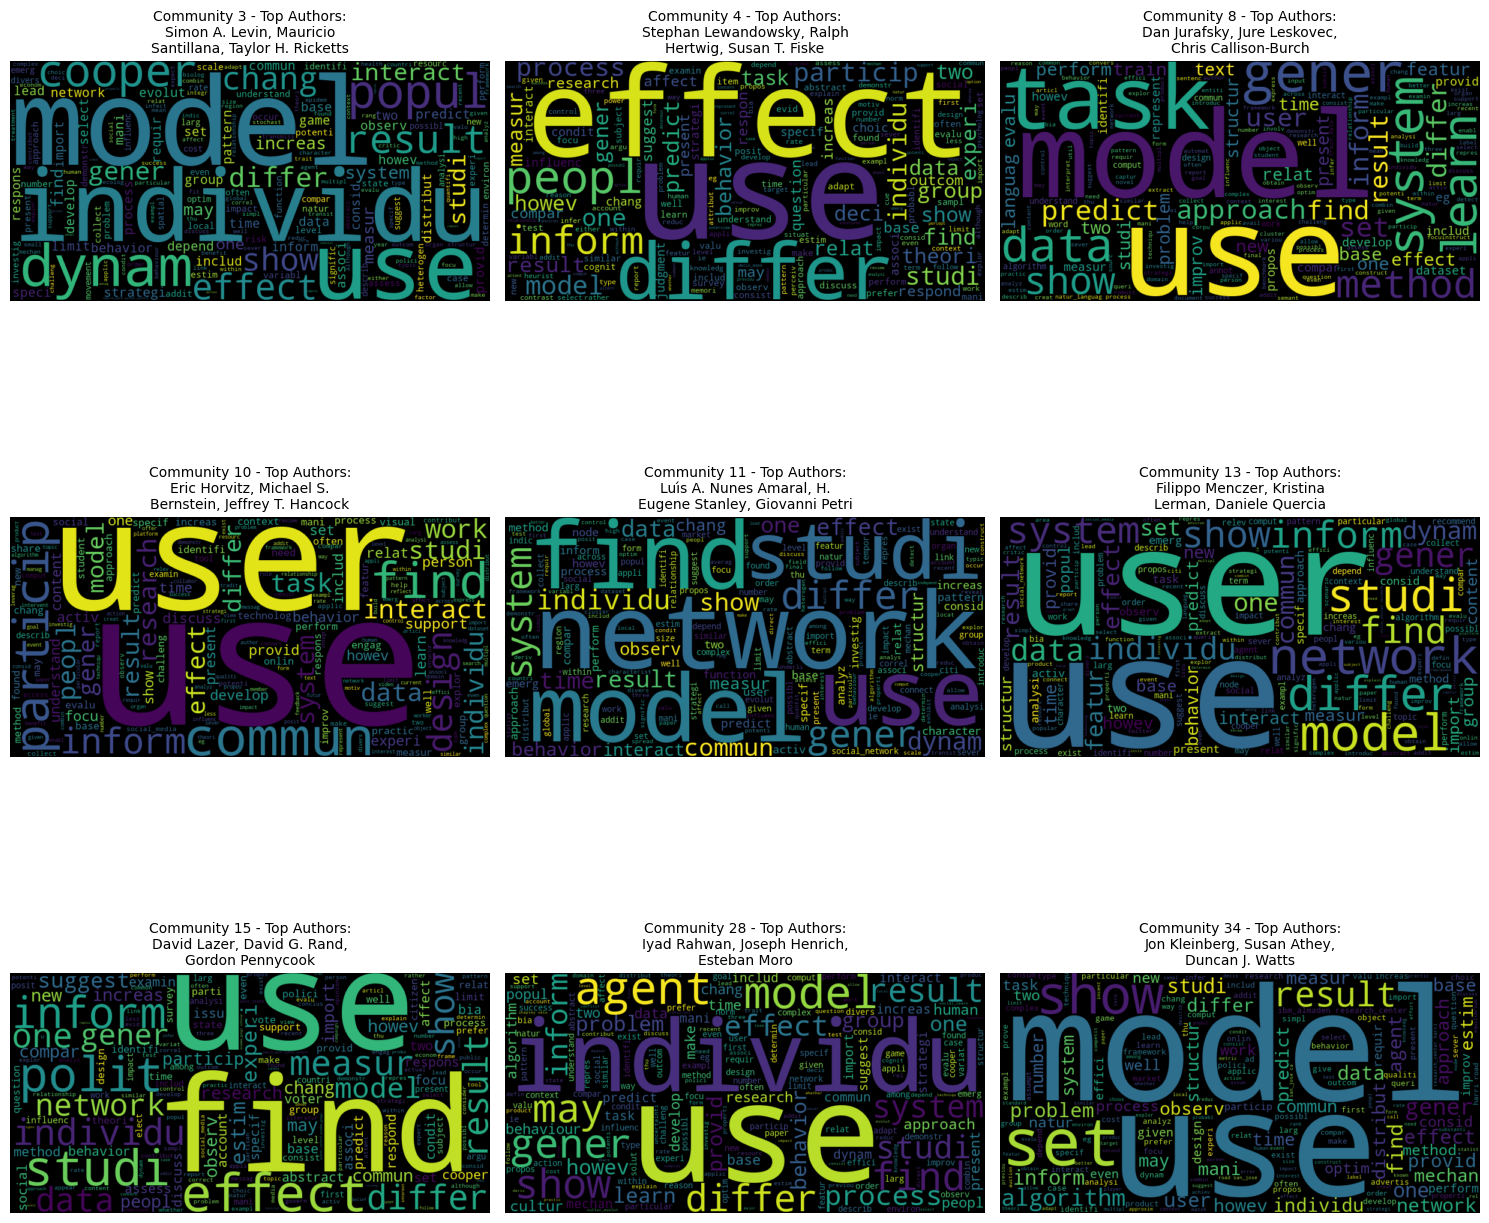

In [288]:
# create the grid for subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # 3x3 grid for 9 communities

# flatten axes for easy iteration
axes = axes.flatten()

# generate and print top 3 authors for each community
for i, (community, group) in enumerate(top_3_authors.groupby("community")):
    print(f"Community {community} - Top 3 authors by degree:")
    print(group[["display_name", "degree"]])

    # generate word cloud for this particular community
    generate_wordcloud_for_community(axes[i], df_top_9_comms, community, top_3_authors)


plt.tight_layout()
plt.show()

Comment on your results. What can you conclude on the different sub-communities in Computational Social Science?

The most prominent words across all sub-communities include "use", "model", "find", "effect", "network", "study", and "individual", suggesting that computational social scientists frequently engage with modeling, understanding effects and interactions, and analyzing networks and individual behaviors.

Some conclusions we could draw are:

- There is a clear division between behavioral and cognitive-focused sub-communities (e.g., Community 4, Community 15) and network, algorithmic, and modeling-focused sub-communities (e.g., Community 11, Community 34).
- Some groups focus on misinformation, human-computer interaction, and decision-making (e.g., Communities 10, 13, 15), while others work on network effects and large-scale computational models (e.g., Communities 11, 28, 34).




Look up online the top author in each community. In light of your search, do your results make sense?

Some examples for the communities are given below.

Community 3, top author is Simon A. Levin who is an ecologist, so it makes sense that the word cloud includes words like "model", "population", "behaviour", aligning with Levin's ecological and environmental research areas. Furthermore, this also makes sense when we look at the list of top 10 TF-IDF words for this community: ['cooper', 'popul', 'influenza', 'individu', 'dynam', 'transmiss', 'speci', 'epidem', 'model', 'leprosi'].

Community 4, top author is Stephan Lewandowsky who is a psychologist. The frequent occurrence of words such as "effect," "use," "different," and "information" indicates an emphasis on cognitive processes, decision-making, and behavioral effects, corresponding with the psychological expertise of the author.

Community 8, top author is Dan Jurafsky who is a computational linguist. The prevalence of terms like "task," "model," "use," and "predict" reflects a focus on natural language processing and machine learning applications in social science.

Community 10, top author is Eric Horvitz who is a computer scientist. The emphasis on words such as "user," "use," and "find" suggests a concentration on human-computer interaction and user behavior analysis, aligning with Horvitz's computer science background.

Community 11, top author is Luís A. Nunes Amaral who is a physicist. The prominence of terms like "find," "system,", "observe" and "studi" indicates a focus on studies regarding systems, which aligns with Amaral's physics background in experimentation, etc.

The top authors in the rest of the communities have interests in computor science, information technology and similar areas, which have applications in many different fields. Hence, their research areas also align with the results. 


### Exercise 3: Computational Social Science

Go back to Week 1, Exercise 1. Revise what you wrote on the topics in Computational Social Science.
In light of your data-driven analysis, has your understanding of the field changed? How?

Initially, we viewed CSS as primarily data-driven social science. Now, we've seen that CSS integrates multiple disciplines: psychology, political science, physics, linguistics, AI, and economics all contribute distinct perspectives. The word cloud and author analysis highlight how different fields bring unique methodologies (e.g., machine learning for text analysis, percolation theory for networks).

Our analysis has reinforced that network science is a core pillar of CSS, connecting disciplines like physics and sociology. Initially, we just thought of networks as just a tool for visualizing relationships, but now we can see how network structures influence phenomena like diffusion, cooperation, and misinformation spread.

Instead of thinking of CSS as a single domain, we can now recognize distinct subfields—some more focused on computational modeling (e.g., network science), while others apply computational tools to study human behavior (e.g., misinformation in political science). The existence of topic clusters, such as human-computer interaction, AI-driven models, and social network dynamics, suggests that CSS is not just about data science but about understanding complex systems through computation.